In [1]:
import os.path as os

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import ModelNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, PointNetConv, fps, global_max_pool, radius
from torch_geometric.typing import WITH_TORCH_CLUSTER

if not WITH_TORCH_CLUSTER:
    quit("This example requires 'torch-cluster'")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# data set imports
import dataset_utils as du
from torch.utils.data import DataLoader, random_split

B = 1 

# load dataset
dataset = du.SDFDataset("./cars995")
train_percent = 0.8

# split dataset into training and validation sets
train_size = int(train_percent * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=B, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}")

Train dataset size: 796, Validation dataset size: 199


In [3]:
def process_batch(batch, np_in=2048, np_q=15000):
    B, N, _ = batch.shape
    assert B == 1, "Batch size must be 1 for now."
    
    # # use surface points
    # surface_points = batch[batch[:, :, 3] == 0]
    idx = torch.randperm(N)[:np_in]
    pos = batch[:, idx, :3] # input positions (B, N, 3) -> (N, 3) # this is what fps expects
    x = batch[0, idx, 3].unsqueeze(-1)
    
    idx = torch.randperm(N)[:np_q]
    query_pos = batch[:, idx, :3] # query positions
    query_sdf = batch[:, idx, 3] # SDF values
    
    batch_vec = torch.zeros(np_in, dtype=torch.long) # batch vector for input points
    
    return x, pos.contiguous().squeeze(0), batch_vec.contiguous().squeeze(0), query_pos.squeeze(0), query_sdf.squeeze(0)

Define Layers and Model

In [4]:
class SAModule(torch.nn.Module):
    def __init__(self, ratio, r, nn):
        super().__init__()
        self.ratio = ratio
        self.r = r
        self.conv = PointNetConv(nn, add_self_loops=False)

    def forward(self, x, pos, batch):
        idx = fps(pos, batch, ratio=self.ratio)
        row, col = radius(pos, pos[idx], self.r, batch, batch[idx],
                          max_num_neighbors=128)
        edge_index = torch.stack([col, row], dim=0)
        x_dst = None if x is None else x[idx]
        x = self.conv((x, x_dst), (pos, pos[idx]), edge_index)
        pos, batch = pos[idx], batch[idx]
        return x, pos, batch


class GlobalSAModule(torch.nn.Module):
    def __init__(self, nn):
        super().__init__()
        self.nn = nn

    def forward(self, x, pos, batch):
        x = self.nn(torch.cat([x, pos], dim=1))
        x = global_max_pool(x, batch)
        pos = pos.new_zeros((x.size(0), 3))
        batch = torch.arange(x.size(0), device=batch.device)
        return x, pos, batch


class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Input channels account for both `pos` and node features.
        self.sa1_module = SAModule(0.5, 0.2, MLP([4, 64, 64, 128]))
        self.sa2_module = SAModule(0.25, 0.5, MLP([128 + 3, 128, 128, 256]))
        self.sa3_module = GlobalSAModule(MLP([256 + 3, 256, 512, 1024]))

        self.encode = MLP([1024, 512, 256], dropout=0.3, norm=None)
        self.sdf = MLP([256 + 3, 128, 64, 1], dropout=0.3, norm=None)

    def forward(self, x, pos, batch, query_pos):
        # encode shape
        sa0_out = (x, pos, batch)
        sa1_out = self.sa1_module(*sa0_out)
        sa2_out = self.sa2_module(*sa1_out)
        sa3_out = self.sa3_module(*sa2_out)
        x, pos, batch = sa3_out
        
        x = self.encode(x)
        x = torch.cat((x.squeeze(0).repeat(query_pos.shape[0], 1), query_pos), dim=-1) # concatenate encoded shape with query positions

        return self.sdf(x)

In [5]:
# # test
# # make random tensor of shape (256, 3) 
# x = torch.randn(1, 256)
# queries = torch.randn(1024, 3) # queries for SDF values

# # want to make a tensor of shape (1024, 256 + 3) where the first 256 columns are the x values and the last 3 columns are the query positions
# x = torch.cat((x.squeeze(0).repeat(1024, 1), queries), dim=-1)  # (1024, 256 + 3)
# mlp = MLP([256 + 3, 128, 64, 1], dropout=0.5, norm=None)  # MLP for SDF prediction
# x = mlp(x)  # (B, 1024, 1)

# print(f"x shape: {x.shape}")
# print(f"queries shape: {queries.shape[1]}")

In [6]:
# test model
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch = next(iter(train_loader))
print(f'Batch shape: {batch.shape}')
x, pos, batch, query_pos, query_sdf = process_batch(batch)
print(f'pos shape: {pos.shape}, query_pos shape: {query_pos.shape}, query_sdf shape: {query_sdf.shape}, x shape: {x.shape}')

print(f'pos shape: {pos.shape}')
# forward pass
output = model(x, pos, batch, query_pos)
# print output shape
print(f"Output shape: {output.shape}")

Batch shape: torch.Size([1, 30000, 4])
pos shape: torch.Size([2048, 3]), query_pos shape: torch.Size([15000, 3]), query_sdf shape: torch.Size([15000]), x shape: torch.Size([2048, 1])
pos shape: torch.Size([2048, 3])
Output shape: torch.Size([15000, 1])


MODEL


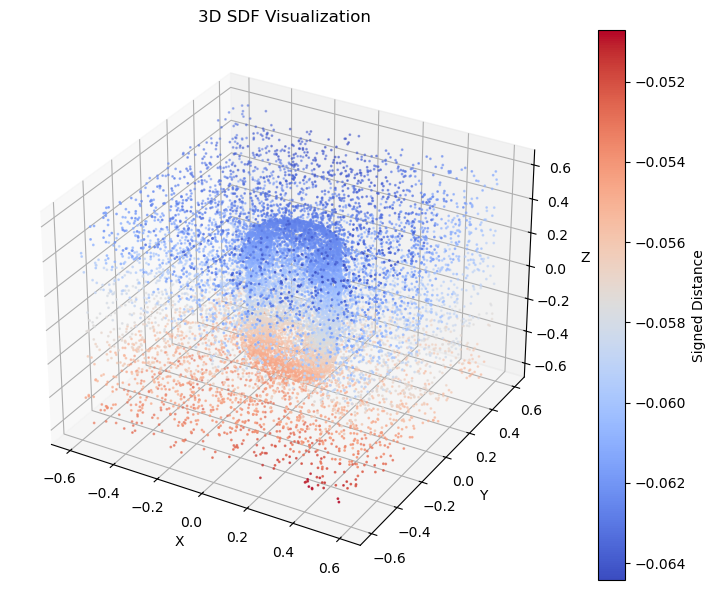

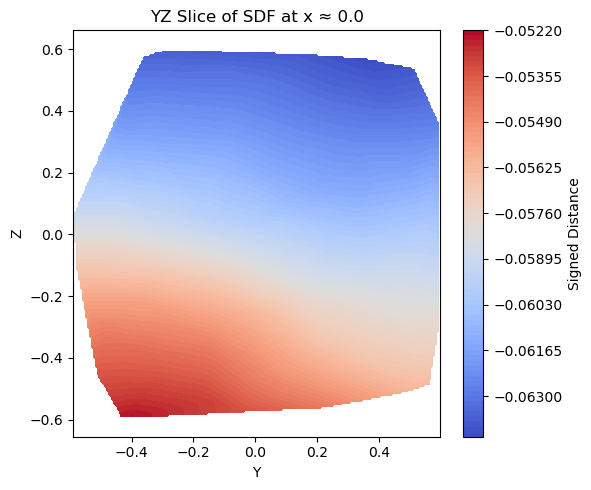

TRUTH


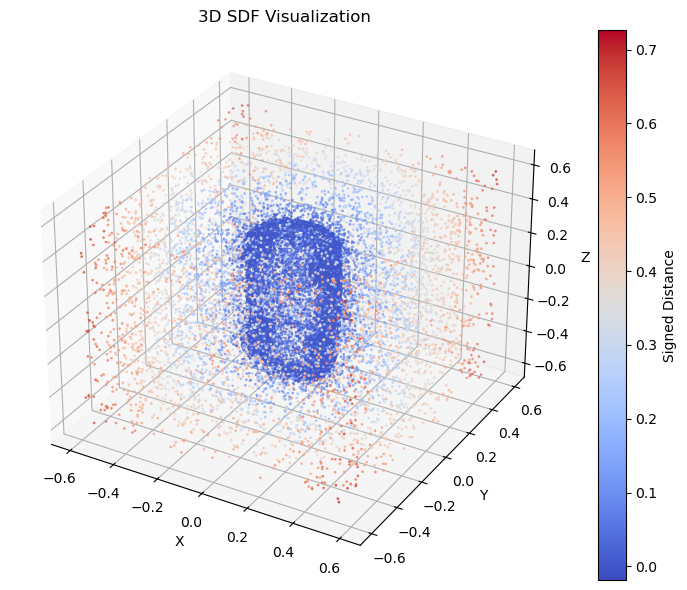

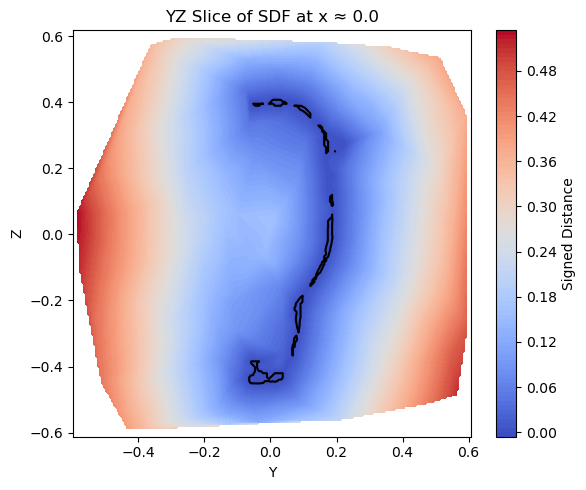

Validation Loss: 0.08381422609090805


In [9]:
def show_validation():
    model.eval()
    batch = next(iter(val_loader))
    x, pos, batch, query_pos, query_sdf = process_batch(batch)
    output = model(x, pos, batch, query_pos)


    prediction = torch.cat((query_pos, output), dim=-1).detach()  # (1024, 3 + 1)
    truth = torch.cat((query_pos, query_sdf.unsqueeze(-1)), dim=-1).detach()  # (1024, 3 + 1)

    print("MODEL")
    du.visualize_sdf_3d(prediction)
    du.visualize_sdf_2d(prediction)
    print("TRUTH")
    du.visualize_sdf_3d(truth)
    du.visualize_sdf_2d(truth)

    loss = F.mse_loss(output.squeeze(-1), query_sdf)  # L1 loss for SDF prediction
    print("Validation Loss:", loss.item())

show_validation()

In [ ]:
from tqdm import tqdm

EPOCHS = 1500

def train(epoch):
    model.train()
    for batch in train_loader:
        x, pos, batch, query_pos, query_sdf = process_batch(batch)
        optimizer.zero_grad()
        out = model(x, pos, batch, query_pos).squeeze(-1)
        loss = F.mse_loss(out, query_sdf)  # L1 loss for SDF prediction
        loss.backward()
        optimizer.step()
    
    return loss.item()


for epoch in tqdm(range(1, EPOCHS + 1)):
    loss = train(epoch)
    if epoch % 20 == 0:
        print('Loss: {:.4f}'.format(loss))
    if epoch % 100 == 0:
        show_validation()
        # save model
        torch.save(model.state_dict(), 'pointnet_sdf.pth')

  0%|          | 0/1000 [00:06<?, ?it/s]


KeyboardInterrupt: 